# Generative Adversarial Net

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary

import torchvision.transforms as tsf
import torchvision as tv

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch

# 1. Load Data

In [17]:
path = 'D:/codes/datasets/CV'
img_size = 28
channels = 1
batch_size = 64

dataloader = DataLoader(datasets.MNIST(path, train=True,
        transform=tsf.Compose(
            [tsf.Resize(img_size), tsf.ToTensor(), tsf.Normalize([0.5], [0.5])]),),
    batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


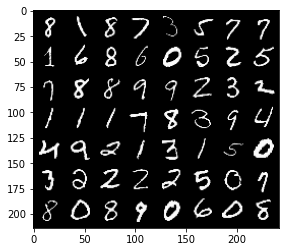

In [18]:
for x,y in dataloader:
    x_ = tv.utils.make_grid(x).numpy().transpose(1,2,0)
    plt.imshow(x_[:28*8-10])
    break

# 2. Models

In [19]:
def layer(in_dim, out_dim, normalize, dropout):
    base = [nn.Linear(in_dim, out_dim)]
    if normalize: base.append(nn.BatchNorm1d(out_dim))
    base.append(nn.Dropout(dropout))
    return base
        
class MLP(nn.Module):
    def __init__(self, layers, normalize, dropout):
        super(MLP, self).__init__()
        clf = []
        for i in range(len(layers)-1):
            clf += layer(layers[i], layers[i+1], normalize, dropout)
        self.clf = nn.Sequential(*clf)
        self.init_para()

    def init_para(self,):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.uniform_()
                m.bias.data.uniform_()

    def forward(self, x):
        x = self.clf(x)
        return x

In [20]:
g_layers = [100, 256, 512, 28*28]
d_layers = [28*28, 512, 256, 1]
lr = 0.01
dropout = 0.5
normalize = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

G = MLP(g_layers, normalize, dropout).to(dev)
op_G = torch.optim.Adam(G.parameters(), lr=lr)

D = MLP(d_layers, normalize, dropout).to(dev)
op_D = torch.optim.Adam(D.parameters(), lr=lr)

In [21]:
summary(G, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
       BatchNorm1d-2                  [-1, 256]             512
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
       BatchNorm1d-5                  [-1, 512]           1,024
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 784]         402,192
       BatchNorm1d-8                  [-1, 784]           1,568
           Dropout-9                  [-1, 784]               0
Total params: 562,736
Trainable params: 562,736
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 2.15
Estimated Total Size (MB): 2.18
-------------------------------------------

In [22]:
summary(D, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
       BatchNorm1d-2                  [-1, 512]           1,024
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5                  [-1, 256]             512
           Dropout-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
       BatchNorm1d-8                    [-1, 1]               2
           Dropout-9                    [-1, 1]               0
Total params: 535,043
Trainable params: 535,043
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
-------------------------------------------

# 3. Training

In [23]:
epochs = 10
latent_dim = 100
Loss = torch.nn.BCELoss().to(dev)

for epoch in range(epochs):
    for (x, _) in tqdm(dataloader, desc='# training: '):
        x = x.view(x.size(0), -1).to(dev)
        valid = torch.ones(x.size(0), 1).to(dev)
        fake = torch.zeros(x.size(0), 1).to(dev)
        z = torch.randn(x.size(0), latent_dim).to(dev) # latent variable

        fake_imgs = F.tanh(G(z)) # generated images
        pred = F.sigmoid(D(fake_imgs))
        # to make fake images look like real
        op_G.zero_grad()
        Loss(pred, valid).backward()
        op_G.step()

        x_ = torch.cat([x, fake_imgs.detach()], dim=0)
        y_ = torch.cat([valid, fake])
        pred = F.sigmoid(D(x_))
        # to detect fake images
        op_D.zero_grad()
        loss = Loss(pred, y_)
        loss.backward()
        op_D.step()

# training: 100%|██████████| 938/938 [00:20<00:00, 44.81it/s]
